In [1]:
library(xgboost)
library(ggplot2)
library(ROCR)
library(SHAPforxgboost)
require(Matrix)
library(tidyxl)

Loading required package: Matrix



In [120]:
source('../../model_functions.R')
source('config/config_cols_modello_sme_v4.R')


path_data <- file.path('../../../data/')


## Data cleaning

In [3]:
lista_master_names <- list.files(file.path(path_data,'RDS/master/sme/'))

lista_master <- lapply(file.path(path_data,'RDS/master/sme/',lista_master_names), function(file){
    dt <- readRDS(file)
})
names(lista_master) <- gsub(".*_(.+).RDS.*", "\\1",lista_master_names)

In [4]:
master_modello <- Reduce(function(x,y) merge(x = x, y = y, by = c("NUM_PRATICA",'PROGRESS_PRATICA')),lista_master)

In [5]:
nrow(master_modello)

[1] 88630

## FILL NA CR E BIL

In [6]:
### FILL NA DI CR CON -1000 tanto i valori sono sempre positivi e gli infiniti CON UN numero alto 
 

cols_cr <- colnames(master_modello)[grepl("CR_",colnames(master_modello))]
master_modello[, (cols_cr) := lapply(.SD, function(x){x[is.infinite(x)] <- 9999999; x}), .SDcols = cols_cr]
master_modello[, (cols_cr) := lapply(.SD, function(x){x[is.na(x)] <- -10000; x}), .SDcols = cols_cr]

master_modello[CR_sconf_acc <  -100,sconf_acc := 'missing']
master_modello[CR_sconf_acc > 100,sconf_acc := 'inf']
master_modello[CR_sconf_acc == 0,sconf_acc := '0']
master_modello[CR_sconf_acc > 0 & CR_sconf_acc<=100,sconf_acc := '>0']


cols_XRA<- colnames(master_modello)[grepl("XRA_",colnames(master_modello))]
master_modello[, (cols_XRA) := lapply(.SD, function(x){x[is.na(x)] <- 0; x}), .SDcols = cols_XRA]

cols_bil <- colnames(master_modello)[grepl("BIL_",colnames(master_modello))]
master_modello[, (cols_bil) := lapply(.SD, function(x){x[is.infinite(x) & x>0 ] <- 9999999; x}), .SDcols = cols_bil]
master_modello[, (cols_bil) := lapply(.SD, function(x){x[is.infinite(x)] <- -9999999; x}), .SDcols = cols_bil]

In [7]:
nrow(master_modello)

[1] 88630

In [8]:
## FILTRI A MONTE

In [9]:
master_modello_filt <- master_modello[is.na(DSI_protesti_certi) | (DSI_protesti_certi ==0) ,]
master_modello_filt <- master_modello_filt[is.na(DSI_fallimenti_certi) | (DSI_fallimenti_certi ==0) ,]

master_modello_filt <- master_modello_filt[is.na(DSI_flag_fallimenti_dubbi) | DSI_flag_fallimenti_dubbi ==FALSE,]

master_modello_filt <- master_modello_filt[is.na(DSI_flag_pregiudizievoli_gravi) | DSI_flag_pregiudizievoli_gravi ==FALSE,]
master_modello_filt <- master_modello_filt[is.na(DSI_procedure_imprese_collegate) | DSI_procedure_imprese_collegate =='  ',]

master_modello_filt <- master_modello_filt[is.na(DSI_flag_procedure_concorsuali) | DSI_flag_procedure_concorsuali ==FALSE,]

n1 <- nrow(master_modello) - nrow(master_modello_filt)
n1

master_modello_filt <- master_modello_filt[DSI_flag_presenza_sofferenze != "ROSSO",]
n2 <- nrow(master_modello) - nrow(master_modello_filt) -n1
n2

master_modello_filt <- master_modello_filt[is.na(DSI_col_fido_con_causale_negativa) | DSI_col_fido_con_causale_negativa != "ROSSO",]

master_modello_filt <- master_modello_filt[is.na(DSI_col_appl_con_causale_negativa) | DSI_col_appl_con_causale_negativa != "ROSSO",]

n3 <- nrow(master_modello) - nrow(master_modello_filt) -n1 -n2

master_modello_filt <- master_modello_filt[is.na(DSI_sab) | (DSI_sab %in% c('2','3','A','non censito')) ,]



master_modello_filt <- master_modello_filt[is.na(DSI_col_presenza_pratica_pef) | DSI_col_presenza_pratica_pef != "GIALLO",]


master_modello_filt <- master_modello_filt[is.na(DSI_parte_correlata) | (DSI_parte_correlata %in% c('missing','non censito')) ,]



master_modello_filt <- master_modello_filt[is.na(FORB_PRESENZA) | FORB_PRESENZA == 0,]

master_modello_filt <- master_modello_filt[is.na(AT_cod_sett) | AT_cod_sett !='MEDIA00',]

master_modello_filt <- master_modello_filt[is.na(COD_TP_CLI),]

master_modello_filt <- master_modello_filt[is.na(COD_CARTIPO),]

master_modello_filt <- master_modello_filt[is.na(DSI_stato_societario) | DSI_stato_societario =='A  A  ATTIVA',]

[1] 1521

[1] 26

In [10]:
nrow(master_modello_filt)/nrow(master_modello)

[1] 0.9340065

In [11]:
master_modello_filt[,flag_exante := "NO"]
master_modello <- merge(master_modello,
                       master_modello_filt[,.(NUM_PRATICA,PROGRESS_PRATICA,flag_exante)],
                       by = c('NUM_PRATICA','PROGRESS_PRATICA'),
                       all.x = TRUE)

In [12]:
#saveRDS(master_modello,'../../../data/RDS/master/master_sme_0606.RDS')

## FILL NA TUTTE LE VARIABILI

In [13]:
master_modello_fill<- master_modello[ , lapply(.SD,function(x) ifelse((is.infinite(x)),NA,x))]

master_modello_fill<- master_modello_fill[ , lapply(.SD,function(x) ifelse((is.na(x) & class(x) %in% c("factor","character")),'missing',x))]
 

# master_modello_fill[is.na(XRA_media_sconfino_30gg),  XRA_media_sconfino_30gg:= 0 ] 
# master_modello_fill[is.na(XRA_IMP_SCONFINO),  XRA_IMP_SCONFINO := 0 ] 
# master_modello_fill[is.na(XRA_IMP_UTIL_TOT), XRA_IMP_UTIL_TOT := 0 ] 
# master_modello_fill[is.na(XRA_NUM_GG_SCONF), XRA_NUM_GG_SCONF := 0 ]
                                                    
master_modello_fill <- master_modello_fill[ , lapply(.SD,function(x) ifelse((is.na(x) & (class(x) %in% c("numeric","integer"))),mean(x,na.rm = TRUE) ,x))]             #mean(x,na.rm = TRUE)                                         

table(master_modello_fill$DSI_parte_correlata,useNA = 'always')
                                           
master_modello_fill <- cbind.data.frame(lapply(master_modello_fill, function(x) {
      if (all(unique(x) %in% c(0,1)))
        as.factor(c("NO", "YES")[x+1])
      else if (all(is.character(x)))
        as.factor(x)
      else
        x
    }))
    setDT(master_modello_fill)

table(master_modello_fill$target)


#master_modello<- master_modello[,which(unlist(lapply(master_modello, function(x)!all(is.na(x))))),with=FALSE]
master_modello_fill<- master_modello_fill[,which(unlist(lapply(master_modello_fill, function(x)!all(is.na(x))))),with=FALSE]


    missing non censito        <NA> 
      36452       52178           0 


DEFAULT      OK 
   3333   85297 

In [14]:
lista_vars_na <- unlist(lapply(colnames(master_modello_fill[,..cols_modello]), function(x){

    perc <- 100*nrow(master_modello_fill[is.na(get(x)),..cols_modello])/nrow(master_modello_fill[,..cols_modello])
    if(perc > 40){
#         print(x)
#         print(100*nrow(master_co[is.na(get(x)),])/nrow(master_co))
        return(x)
    }else
        return(NULL)
}))
lista_vars_na

NULL

In [15]:
lista_vars_missing <- unlist(lapply(colnames(master_modello[,..cols_modello]), function(x){

    perc <- 100*nrow(master_modello[is.na(get(x)),..cols_modello])/nrow(master_modello[,..cols_modello])
    if(perc > 40){
#         print(x)
#         print(100*nrow(master_co[is.na(get(x)),])/nrow(master_co))
        return(x)
    }else
        return(NULL)
}))
lista_vars_missing

[1] "BIL_onerifin_ebitda"    "BIL_PFN_Ebitda"         "CRA_andamento"         
[4] "DSI_presenza_fidi_ced"  "AT_cod_sett_cedente"    "EWS_ASIS"              
[7] "RAT_classe_rating_filt" "RAT_andamento"

## MODELLO

In [121]:
modello_smer <- compute_model(
    master_modello_fill[flag_exante == 'NO',..cols_modello],
    suffix="sme",cp = 0.0001,seed = 1111,minbuck= 0.0005, 
    use_surr = 10, perc_split = 0.80,desc = 'sme')

[1] 66224
[1] 16557


Warning message in rpart.control(cp = cp, minbucket = minbuck * length(rows), maxsurrogate = maxsurr, :
“The value of 'usesurrogate' supplied was out of range, the default value of 2 is used instead.”


[1] 5


Using 'N' as value column. Use 'value.var' to override



In [ ]:
train <- master_modello_fill[flag_exante == 'NO',..cols_modello][modello_smer$rows]
test <- master_modello_fill[flag_exante == 'NO',..cols_modello][-modello_smer$rows]

write.csv(train, '../sme/output/dt_train_sme.csv')
write.csv(test, '../sme/output/dt_test_sme.csv')

In [ ]:
feat_imp <- setDT(data.frame(imp = round(modello_smer$model$variable.importance,4)), keep.rownames = TRUE)
colnames(feat_imp) <- c('nome_var','F_imp')

tab_variabili <- data.table(nome_var = colnames(master_modello_fill), valorizzata = !(colnames(master_modello_fill)%in%lista_vars_na))
tab_variabili <- merge(tab_variabili,
                      feat_imp,
                      by = 'nome_var',
                      all.x = TRUE)

In [ ]:
tab_variabili <- tab_variabili[order(-F_imp)]
tab_variabili[,ordine_albero := (1:nrow(tab_variabili))]

In [ ]:
require(ggplot2)

In [ ]:
p <- ggplot(tab_variabili[!is.na(F_imp),], aes(x=reorder(nome_var,F_imp), y=F_imp,fill=F_imp))+ 
        geom_bar(stat="identity", position="dodge")+ coord_flip()+
        ylab("Variable Importance")+
        xlab("")+
        ggtitle("Information Value Summary")+
        guides(fill=F)+
        scale_fill_gradient(low="cyan", high="blue")+
        theme(axis.text=element_text(size=16))

In [ ]:
ggsave(
    filename = paste0(
        "output/",gsub("-","",Sys.Date()),"/",
        gsub(":","",substr(Sys.time(),12,20)),"featImp_SME.png"
    ), 
    width = 300, height = 450,
    units = "mm",
    dpi = 320,
    p
)

In [ ]:
model_frame <- as.data.table(modello_smer$model$frame)
model_frame[,type := 'leaf']
model_frame[var != '<leaf>',type := 'other']

modello_smer$tree_table[,round_pred := round(as.numeric(pred_vpc),7) ]
model_frame[,round_pred := round(yval2.V4,7) ]

In [ ]:
dt_tree <-unique(merge(modello_smer$tree_table,
                       model_frame[,c('var','type','round_pred')], 
                       by = 'round_pred',
                       all.x = TRUE))

dt_tree[, lift := round(prob/(sum(DEFAULT)/sum(tot)),1)]
dt_tree[, def_cumulato := cumsum(DEFAULT)]
dt_tree[, tot_cumulato := cumsum(tot)]
dt_tree[, td_cumulato := def_cumulato/tot_cumulato]

In [ ]:
write.xlsx(dt_tree[type == "leaf",.(pred_vpc,DEFAULT,tot,def_cumulato,tot_cumulato,td_cumulato)],
           'table_foglie_sme.xlsx',
           row.names = FALSE)

In [ ]:
dt_sample_all <- merge(modello_smer$pred,dt_orig[,c('NUM_PRATICA',"PROGRESS_PRATICA",'ESITO_FINALE_VPC')],by.x = c('NUM_PRATICA',"PROGRESS_PRATICA"), by.y = c('NUM_PRATICA',"PROGRESS_PRATICA"),all.x = TRUE,
                suffixes = c("","_y"))

leaves_val <- unique(dt_tree[type != 'other', pred_vpc])
other_val <- unique(dt_tree[type == 'other', pred_vpc])
# leaves_val
# other_val

dt_sample <- dt_sample_all[pred_vpc %in% leaves_val,]

## ROC


In [104]:
model_frame <- as.data.table(modello_smer$model$frame)
model_frame[,type := 'leaf']
model_frame[var != '<leaf>',type := 'other']

dt_pred_tree <- merge(modello_smer$pred,
                      unique(model_frame[type =='leaf',.(yval2.V4,type,n)]),
                      by.x ='pred_vpc', 
                      by.y = 'yval2.V4', 
                      all.x = TRUE )


In [35]:
sum(modello_smer$tree_table$tot)

[1] 16557

[1] 0.7144105


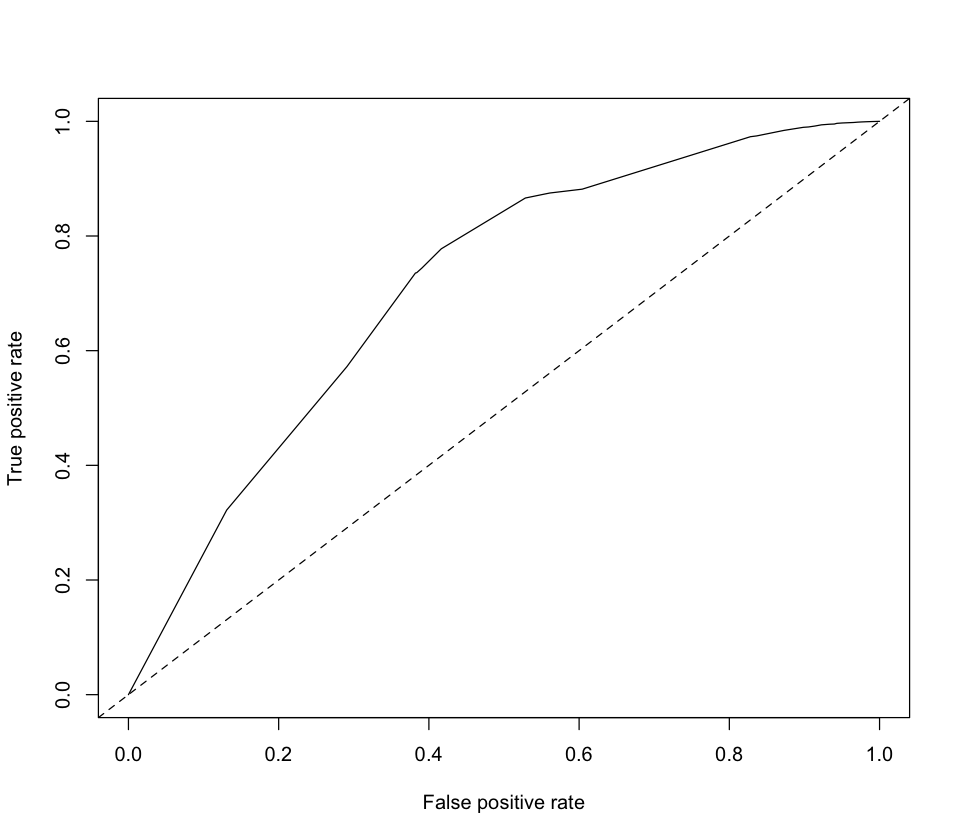

In [36]:
pred_test <- prediction(predict(modello_smer$model, dt_pred_tree, type="prob")[, 2], dt_pred_tree$target)

auc_ROCR <- performance(pred_test, measure = "auc")
print(auc_ROCR@y.values[[1]])

plot(performance(pred_test, measure = "tpr", x.measure = "fpr"),)
abline(0, 1, lty = 2)
png('plot_sme.jpg')
plot(x = performance(pred_test, measure = "tpr", x.measure = "fpr")@x.values[[1]],y = performance(pred_test, measure = "tpr", x.measure = "fpr")@y.values[[1]],type="l", pch = 16,col = 'forestgreen',ylab = 'True positive rate',xlab = 'False positive rate')
abline(0,1, lty = 2)

[1] "roc"


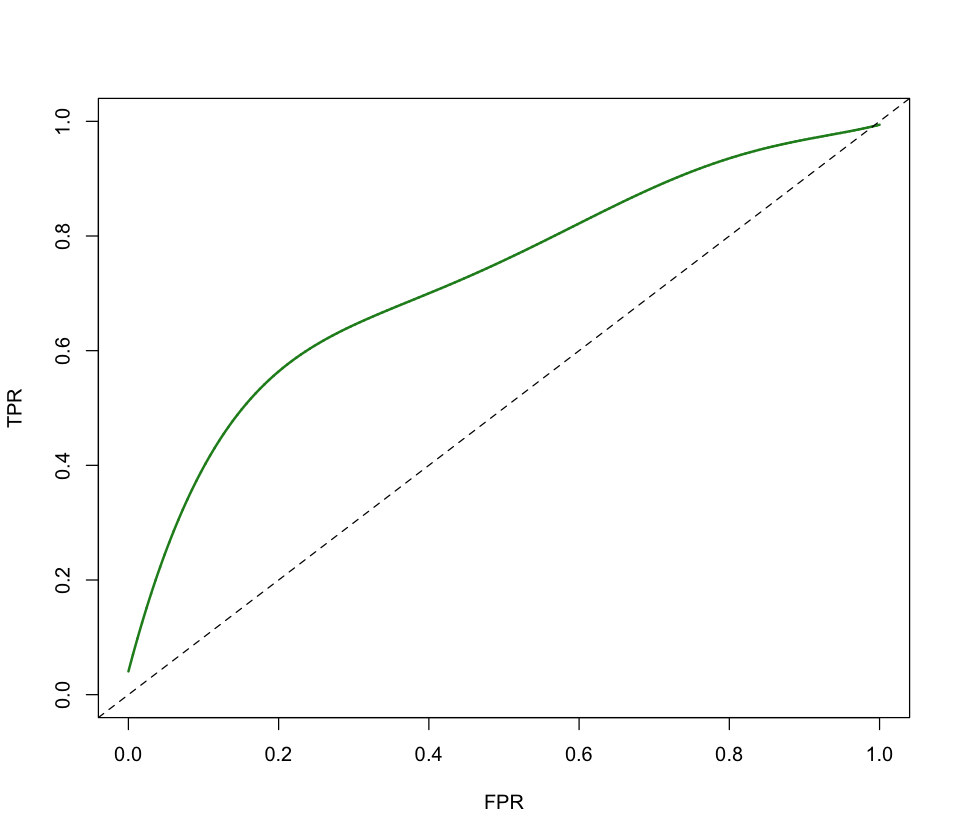

In [37]:
require(pracma)

rocvalues<-function(predictions, results, type=c("roc","gain")) {
	type<-match.arg(type)
    print(type)
	indici<-order(predictions,decreasing=TRUE)
	vec<-results[indici]
	y<-cumsum(vec)/sum(results) #cumulative positive rate
	if (type=="gain") x<-seq_along(results)/length(results) else x<-cumsum(!vec)/sum(!vec) #percentage of sample
	ritorno<-list(x=x,y=y)
	attr(ritorno,"AUC")<-trapz(x,y)
	ritorno
}

test <- dt_sample
test[,target2:=ifelse(target=="DEFAULT",1,0)]
roc <-rocvalues(test$pred_vpc, test$target2)


rocDT<-data.table(x=roc$x, y=roc$y)
plot(roc$x, roc$y, cex=.1, col='white',pch=15, xlab = 'FPR', ylab = 'TPR')

fit4 <- lm(y~poly(x,4,raw=TRUE), data=rocDT)
fit5 <- lm(y~poly(x,5,raw=TRUE), data=rocDT)
fit6 <- lm(y~poly(x,6,raw=TRUE), data=rocDT)


x_axis <- seq_along(test$target2)/length(test$target2)
#lines(x_axis, predict(fit4, data.frame(x=x_axis)), col='green', lwd=2)
lines(x_axis, predict(fit5, data.frame(x=x_axis)), col='forestgreen', lwd=2)
#lines(x_axis, predict(fit6, data.frame(x=x_axis)), col='blue', lwd=2)
abline(0,1, lty = 2)



## TEST OVERFITTING

[1] 0.7498303


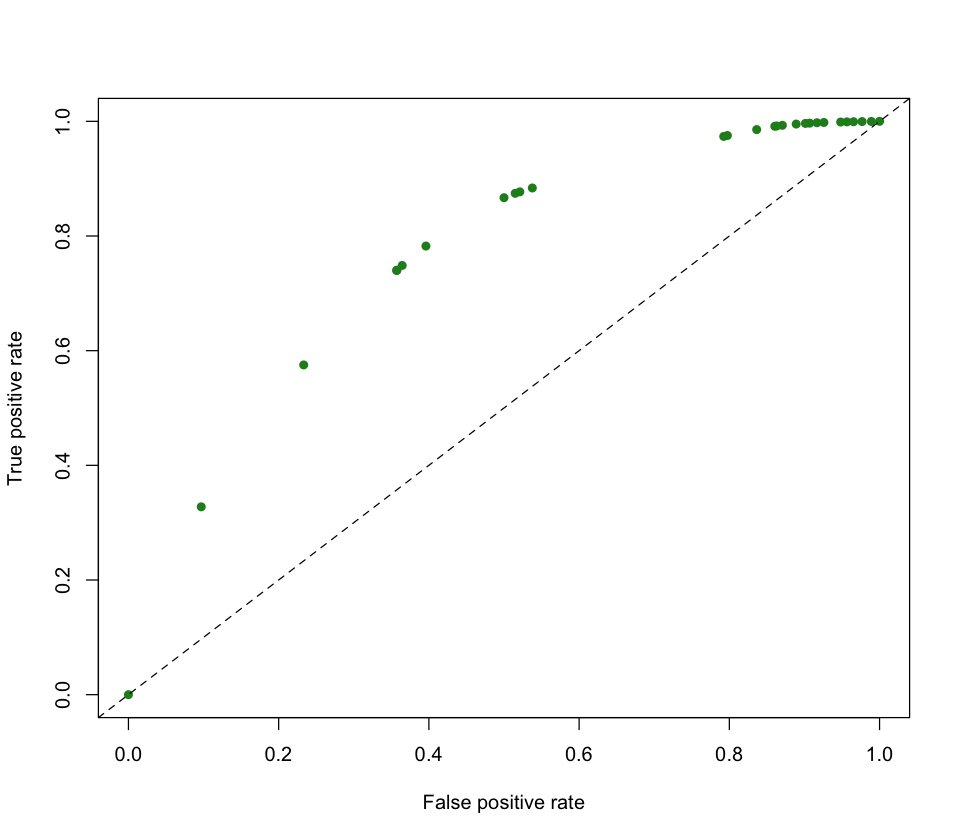

In [42]:
train <-  master_modello_fill[flag_exante == 'NO',..cols_modello][modello_smer$rows,]

pred_test <- prediction(predict(modello_smer$model, train, type="prob")[, 2], train$target)

auc_ROCR <- performance(pred_test, measure = "auc")
print(auc_ROCR@y.values[[1]])

# plot(performance(pred_test, measure = "tpr", x.measure = "fpr"),)
# abline(0, 1, lty = 2)
#png('plot_sme.jpg')
plot(x = performance(pred_test, measure = "tpr", x.measure = "fpr")@x.values[[1]],y = performance(pred_test, measure = "tpr", x.measure = "fpr")@y.values[[1]],type="p", pch = 16,col = 'forestgreen',ylab = 'True positive rate',xlab = 'False positive rate')
abline(0,1, lty = 2)
#dev.off()

In [43]:
# dt_tree[type != 'other',]

# soglia_vg <- 0.09
# soglia_gr <- 0.1
# merge(table_soglie(dt_tree[type != 'other',],soglie = c(soglia_vg,soglia_gr)),
#       performance_oldvpc(dt_sample),
#       by = 'colore')


# table(dt_sample[pred_vpc <= 0.09  ,CRA_andamento])

# dt_sample_small <- dt_sample[,.(ESITO_FINALE_VPC,pred_vpc,target,NUM_PRATICA, PROGRESS_PRATICA)]
# dt_sample_small[, col_new_vpc := "giallo"]
# dt_sample_small[pred_vpc <= soglia_vg, col_new_vpc := "verde"]
# dt_sample_small[pred_vpc > soglia_gr, col_new_vpc := "rosso"]

# colnames(dt_orig)[grepl('final',colnames(dt_orig))]

# dt_sample_limsoc <- merge(dt_sample_small,
#                          dt_orig[,.(NUM_PRATICA, PROGRESS_PRATICA,`Colore - LIMITI SOCIETARI`, `Esito_final_giallo e Monocontrollo_giallo`)],
#                          by =c('NUM_PRATICA', 'PROGRESS_PRATICA'),
#                          all.x = TRUE)

# #table(dt_sample_limsoc[pred_vpc <= 0.1 & `Colore - LIMITI SOCIETARI` == "GIALLO" , ]$pred_vpc, useNA = 'always')

# table(dt_sample_limsoc[ `Colore - LIMITI SOCIETARI` == "ROSSO" & col_new_vpc == 'verde', target ])

# dt_sam_appo <- dt_sample_small[target == "DEFAULT",.(N= .N ), by = c('ESITO_FINALE_VPC','col_new_vpc')]

# migr_mat_def <- reshape(dt_sam_appo, idvar = "ESITO_FINALE_VPC", timevar = "col_new_vpc", direction = "wide")

# colnames(migr_mat_def) <- gsub("N\\.","New_",colnames(migr_mat_def))
# migr_mat_def <- migr_mat_def[,sort(colnames(migr_mat_def)), with = FALSE][order(ESITO_FINALE_VPC)]

# dt_sam_appo <- dt_sample_small[target != "DEFAULT",.(N= .N ), by = c('ESITO_FINALE_VPC','col_new_vpc')]

# migr_mat_bon <- reshape(dt_sam_appo, idvar = "ESITO_FINALE_VPC", timevar = "col_new_vpc", direction = "wide")

# colnames(migr_mat_bon) <- gsub("N\\.","New_",colnames(migr_mat_bon))
# migr_mat_bon <- migr_mat_bon[,sort(colnames(migr_mat_bon)), with = FALSE][order(ESITO_FINALE_VPC)]



# migr_mat_def <- data.frame(migr_mat_def)
# rownames(migr_mat_def) <- migr_mat_def$ESITO_FINALE_VPC
# migr_mat_def$ESITO_FINALE_VPC <- NULL
# migr_mat_def<- cbind(migr_mat_def, total = rowSums(migr_mat_def))
# migr_mat_def<- rbind(migr_mat_def, total = colSums(migr_mat_def))
# #rownames(migr_mat_def) <- c(migr_mat_def$ESITO_FINALE_VPC,"total")
# migr_mat_def



# migr_mat_bon <- data.frame(migr_mat_bon)
# rownames(migr_mat_bon) <- migr_mat_bon$ESITO_FINALE_VPC
# migr_mat_bon$ESITO_FINALE_VPC <- NULL
# migr_mat_bon<- cbind(migr_mat_bon, total = rowSums(migr_mat_bon))
# migr_mat_bon<- rbind(migr_mat_bon, total = colSums(migr_mat_bon))

# migr_mat_bon

# dt_sample_rossiverdi <- merge(dt_sample_small[col_new_vpc == "verde" & ESITO_FINALE_VPC == "ROSSO",.(pred_vpc,NUM_PRATICA, PROGRESS_PRATICA) ],
#                              dt_orig,
#                              by = c('NUM_PRATICA',"PROGRESS_PRATICA"),
#                              all.x = TRUE)

# dt_sample_rossi_def <- dt_sample_rossiverdi[target == "DEFAULT",]
# dt_sample_rossiverdi[target == "DEFAULT" & `Colore - LIMITI SOCIETARI`!= "ROSSO",colnames(dt_sample_rossiverdi)[grepl('ROSSO',dt_sample_rossiverdi)], with = FALSE ]
# #colnames(dt_sample_rossiverdi)[grepl('ROSSO',dt_sample_rossiverdi)], with = FALSE 

# dt_sample_rossi_def[`Colore - LIMITI SOCIETARI`!= "ROSSO",colnames(dt_sample_rossi_def)[grepl('Colore -',colnames(dt_sample_rossi_def))], with = FALSE]

# dt_appo <-dt_sample_rossi_def[`Colore - LIMITI SOCIETARI`!= "ROSSO",colnames(dt_sample_rossi_def)[grepl('Colore -',colnames(dt_sample_rossi_def))], with = FALSE]
# unlist(lapply(colnames(dt_appo), function(x){
#    # if(nrow(dt_appo[get(x) == "ROSSO",]) >1){
#          print(x)
#     print(nrow(dt_appo[get(x) == "ROSSO",]))
#    # }
  
# }))


# dt_sample_check <- merge(dt_sample_small[,.(col_new_vpc,pred_vpc,NUM_PRATICA, PROGRESS_PRATICA) ],
#                              dt_orig,
#                              by = c('NUM_PRATICA',"PROGRESS_PRATICA"),
#                              all.x = TRUE)

# table(dt_sample_check$`Colore - BILANCI :PATRIMONIO NET`,useNA = 'always')

# table(dt_sample_check[`Colore - BILANCI :PATRIMONIO NET` == 'ROSSO', .(col_new_vpc,pred_vpc, ESITO_FINALE_VPC,target)]$col_new_vpc)

# dt_sample_check[col_new_vpc == 'giallo' & `Colore - LIMITI SOCIETARI`== "ROSSO",]

# dt_sample_gialliverdi <- merge(dt_sample_small[col_new_vpc == "verde" & ESITO_FINALE_VPC == "GIALLO",.(pred_vpc,NUM_PRATICA, PROGRESS_PRATICA) ],
#                              dt_orig,
#                              by = c('NUM_PRATICA',"PROGRESS_PRATICA"),
#                              all.x = TRUE)

# #dt_sample_gialliverdi[target == "DEFAULT",]

# dt_sample_gialli_def <- dt_sample_gialliverdi[target == "DEFAULT",]
# dt_sample_gialli_def[ `Colore - LIMITI SOCIETARI`!= "GIALLO" ,colnames(dt_sample_gialli_def)[grepl('GIALLO',dt_sample_gialli_def)], with = FALSE ]

# dt_appo <-dt_sample_gialli_def[ `Colore - LIMITI SOCIETARI`!= "GIALLO" ,colnames(dt_sample_gialli_def)[grepl('GIALLO',dt_sample_gialli_def)], with = FALSE ]
# unlist(lapply(colnames(dt_appo), function(x){
#     if(nrow(dt_appo[get(x) == "GIALLO",]) >1){
#          print(x)
#     print(nrow(dt_appo[get(x) == "GIALLO",]))
#     }
  
# }))


## PERFORMANCE SLIDE

In [49]:
solo_censiti <- FALSE

In [50]:
dt_sample_all <- merge(modello_smer$pred,dt_orig[,c('NUM_PRATICA',"PROGRESS_PRATICA",'ESITO_FINALE_VPC')],by.x = c('NUM_PRATICA',"PROGRESS_PRATICA"), by.y = c('NUM_PRATICA',"PROGRESS_PRATICA"),all.x = TRUE,
                suffixes = c("","_y"))

In [51]:
model_frame <- as.data.table(modello_smer$model$frame)
model_frame[,type := 'leaf']
model_frame[var != '<leaf>',type := 'other']

modello_smer$tree_table[,round_pred := round(as.numeric(pred_vpc),7) ]
model_frame[,round_pred := round(yval2.V4,7) ]

dt_tree <-unique(merge(modello_smer$tree_table,
                       model_frame[,c('var','type','round_pred')], 
                       by = 'round_pred',
                       all.x = TRUE))


In [52]:
dt_sample <-merge(dt_sample_all,
                 master_modello[,.(NUM_PRATICA, PROGRESS_PRATICA,Classificazione_Cliente)],
                 by = c('NUM_PRATICA', 'PROGRESS_PRATICA'),
                 all.x = TRUE)

In [53]:
if(solo_censiti){
    dt_sample <- dt_sample[Classificazione_Cliente =='CLIENTE', ]
dt_tree <- dt_sample_censiti[,.(DEFAULT = sum(target == "DEFAULT"), OK = sum(target == "OK"),tot = .N), by = 'pred_vpc'][order(pred_vpc)]
}


## ANALISI PERFORMANCE 

In [54]:
table_performance <- dt_tree[,.(pred_vpc,DEFAULT,OK,tot)]
table_performance[, tot_verdi := round(100*cumsum(tot)/sum(tot),2)]
table_performance[, lift_verde := round((cumsum(DEFAULT)/cumsum(tot))/(sum(DEFAULT)/sum(tot)),2)]
table_performance <- table_performance[order(-pred_vpc)]

table_performance[,td_foglia := round(100*DEFAULT/tot,2)]
table_performance[,def_cum := cumsum(DEFAULT)]
table_performance[,ok_cum := cumsum(OK)]
table_performance[,tot_cum := cumsum(tot)]


table_performance[,recall := round(100*(def_cum-DEFAULT)/sum(DEFAULT),2)]
table_performance[,precision :=  round(100*def_cum/tot_cum,2)]
table_performance[,accuracy :=  round(100*(def_cum+sum(OK) - ok_cum)/sum(tot),2)]
table_performance[,lift := round((def_cum/tot_cum)/(sum(DEFAULT)/sum(tot)),2)]

cat('tot default',sum(table_performance$DEFAULT))
cat('\ntot ok',sum(table_performance$OK))
cat('\ntot ',sum(table_performance$tot))
cat('\ntd ',round(100*sum(table_performance$DEFAULT)/sum(table_performance$tot),2))
table_performance[,pred_vpc := as.numeric(pred_vpc)]
table_performance

tot default 581
tot ok 15976
tot  16557
td  3.51

pred_vpc,DEFAULT,OK,tot,tot_verdi,lift_verde,td_foglia,def_cum,ok_cum,tot_cum,recall,precision,accuracy,lift
<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0.67567568,5,5,10,100.00,1.00,50.00,5,5,10,0.00,50.00,96.49,14.25
0.66666667,5,6,11,99.94,0.99,45.45,10,11,21,0.86,47.62,96.48,13.57
0.57777778,4,6,10,99.87,0.98,40.00,14,17,31,1.72,45.16,96.47,12.87
0.55555556,3,6,9,99.81,0.98,33.33,17,23,40,2.41,42.50,96.45,12.11
0.52777778,3,9,12,99.76,0.97,25.00,20,32,52,2.93,38.46,96.42,10.96
0.51515152,9,14,23,99.69,0.97,39.13,29,46,75,3.44,38.67,96.39,11.02
0.41176471,4,10,14,99.55,0.95,28.57,33,56,89,4.99,37.08,96.35,10.57
0.32352941,2,19,21,99.46,0.95,9.52,35,75,110,5.68,31.82,96.25,9.07
0.30952381,4,6,10,99.34,0.95,40.00,39,81,120,6.02,32.50,96.24,9.26


In [55]:
if(solo_censiti){
    write.xlsx(table_performance, 'table_performance_v4_clienti.xlsx', row.names= FALSE)
}else{
    write.xlsx(table_performance, 'table_performance_v4.xlsx', row.names= FALSE)
}

In [56]:
cat('tot default',sum(table_performance$DEFAULT))
cat('\ntot ok',sum(table_performance$OK))
cat('\ntot ',sum(table_performance$tot))
cat('\ntd ',round(100*sum(table_performance$DEFAULT)/sum(table_performance$tot),2))
table_performance[,pred_vpc := as.numeric(pred_vpc)]
table_performance

tot default 581
tot ok 15976
tot  16557
td  3.51

pred_vpc,DEFAULT,OK,tot,tot_verdi,lift_verde,td_foglia,def_cum,ok_cum,tot_cum,recall,precision,accuracy,lift
<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0.67567568,5,5,10,100.00,1.00,50.00,5,5,10,0.00,50.00,96.49,14.25
0.66666667,5,6,11,99.94,0.99,45.45,10,11,21,0.86,47.62,96.48,13.57
0.57777778,4,6,10,99.87,0.98,40.00,14,17,31,1.72,45.16,96.47,12.87
0.55555556,3,6,9,99.81,0.98,33.33,17,23,40,2.41,42.50,96.45,12.11
0.52777778,3,9,12,99.76,0.97,25.00,20,32,52,2.93,38.46,96.42,10.96
0.51515152,9,14,23,99.69,0.97,39.13,29,46,75,3.44,38.67,96.39,11.02
0.41176471,4,10,14,99.55,0.95,28.57,33,56,89,4.99,37.08,96.35,10.57
0.32352941,2,19,21,99.46,0.95,9.52,35,75,110,5.68,31.82,96.25,9.07
0.30952381,4,6,10,99.34,0.95,40.00,39,81,120,6.02,32.50,96.24,9.26


In [57]:
performance_prelim <- function(dt){
    rbindlist(lapply(c("VERDE","GIALLO","ROSSO"),function(x){
       dt_appo <- dt[colore_senza_limsoc == x,
                 list(colore = x,
                      DEFAULT = nrow(dt[target=='DEFAULT' &colore_senza_limsoc==x ,]),
                      OK = nrow(dt[target=='OK' &colore_senza_limsoc==x ,]),
                      old_tot = nrow(dt[colore_senza_limsoc==x ,]))]
              dt_appo[,old_td := round(100*DEFAULT/old_tot,3)]
       dt_appo[,sample_perc := round(100*old_tot/nrow(dt),3)]
       })
   )
}


performance_newlim <- function(dt){
    rbindlist(lapply(c("VERDE","GIALLO","ROSSO"),function(x){
       dt_appo <- dt[esito_finale_new_lim == x,
                 list(colore = x,
                      DEFAULT = nrow(dt[target=='DEFAULT' &esito_finale_new_lim==x ,]),
                      OK = nrow(dt[target=='OK' &esito_finale_new_lim==x ,]),
                      old_tot = nrow(dt[esito_finale_new_lim==x ,]))]
              dt_appo[,old_td := round(100*DEFAULT/old_tot,3)]
       dt_appo[,sample_perc := round(100*old_tot/nrow(dt),3)]
       })
   )
}


dt_sample_small <- merge(dt_sample[,.(ESITO_FINALE_VPC,pred_vpc,target,NUM_PRATICA, PROGRESS_PRATICA)],
                         master_modello[,.(NUM_PRATICA,PROGRESS_PRATICA,DSI_importo_fido_richiesto, DSI_sab,RAT_classe_rating_filt)],
                         by = c('NUM_PRATICA','PROGRESS_PRATICA'),
                         all.x = TRUE)



dt_sample_limsoc <- merge(dt_sample_small,
                         dt_orig[,.(NUM_PRATICA, PROGRESS_PRATICA,LIMITE_MAX,`Esito - LIMITI SOCIETARI`,`Colore - LIMITI SOCIETARI`, `Esito_final_giallo e Monocontrollo_giallo`)],
                         by =c('NUM_PRATICA', 'PROGRESS_PRATICA'),
                         all.x = TRUE)

dt_sample_limsoc[,new_limiti := LIMITE_MAX]
dt_sample_limsoc[grepl("I",RAT_classe_rating_filt),new_limiti := 500000]

dt_sample_limsoc[DSI_importo_fido_richiesto >new_limiti ,new_col_limiti := "GIALLO"]
dt_sample_limsoc[DSI_importo_fido_richiesto <= new_limiti ,new_col_limiti := "VERDE"]
dt_sample_limsoc[LIMITE_MAX == 0 ,new_col_limiti := "ROSSO"]
dt_sample_limsoc[DSI_importo_fido_richiesto == 0 ,new_col_limiti := "VERDE"]
dt_sample_limsoc[grepl("R",RAT_classe_rating_filt) & RAT_classe_rating_filt!= 'UR',new_col_limiti := "ROSSO"]

cols_color <- c(colnames(dt_orig)[grepl("Colore -",colnames(dt_orig)) & !grepl('LIMITI SOCIETARI',colnames(dt_orig))])

dt_sample_limsoc <- merge(dt_sample_limsoc,
                          dt_orig[, c("NUM_PRATICA","PROGRESS_PRATICA",cols_color), with = FALSE],
                          by =  c("NUM_PRATICA","PROGRESS_PRATICA"),
                           all.x = TRUE)

dt_sample_limsoc[, new_num_limiti := as.numeric(factor(new_col_limiti, levels = c('NERO','GRIGIO','VERDE','GIALLO','ROSSO')))]

In [58]:

dt_color <- dt_orig[,c("NUM_PRATICA","PROGRESS_PRATICA","ESITO_FINALE_VPC",cols_color), with = FALSE]

dt_color[, (cols_color) := lapply(dt_color[,cols_color, with = FALSE], function(col){
        as.numeric(factor(col, levels = c('NERO','GRIGIO','VERDE','GIALLO','ROSSO')))
})]

dt_color[, col_senzalimiti := do.call(pmax, c(.SD, list(na.rm = TRUE))), .SDcols=cols_color]


In [59]:

dt_sample_limsoc <- merge(dt_sample_limsoc,
                         dt_color[, c("NUM_PRATICA","PROGRESS_PRATICA",'col_senzalimiti')],
                         by = c("NUM_PRATICA","PROGRESS_PRATICA"),
                         all.x = TRUE)
dt_sample_limsoc[col_senzalimiti ==3, colore_senza_limsoc := "VERDE"]
dt_sample_limsoc[col_senzalimiti ==4, colore_senza_limsoc := "GIALLO"]
dt_sample_limsoc[col_senzalimiti ==5, colore_senza_limsoc := "ROSSO"]
dt_sample_limsoc[is.na(col_senzalimiti), colore_senza_limsoc := ESITO_FINALE_VPC]
dt_sample_limsoc[is.na(col_senzalimiti), col_senzalimiti := 0]

dt_sample_limsoc[, esito_finale_new_lim_num := do.call(pmax, c(.SD, list(na.rm = TRUE))), .SDcols=c('col_senzalimiti','new_num_limiti')]

dt_sample_limsoc[esito_finale_new_lim_num ==3, esito_finale_new_lim := "VERDE"]
dt_sample_limsoc[esito_finale_new_lim_num ==4, esito_finale_new_lim := "GIALLO"]
dt_sample_limsoc[esito_finale_new_lim_num ==5, esito_finale_new_lim := "ROSSO"]
dt_sample_limsoc[esito_finale_new_lim_num ==0, esito_finale_new_lim := ESITO_FINALE_VPC]



In [60]:

performance_oldvpc(dt_sample_limsoc)
performance_prelim(dt_sample_limsoc)
performance_newlim(dt_sample_limsoc)

colore,DEFAULT,OK,old_tot,old_td,sample_perc
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
VERDE,416,12634,13050,3.188,78.819
GIALLO,75,1952,2027,3.700,12.243
ROSSO,90,1390,1480,6.081,8.939


colore,DEFAULT,OK,old_tot,old_td,sample_perc
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
VERDE,468,12887,13355,3.504,80.661
GIALLO,72,2160,2232,3.226,13.481
ROSSO,41,929,970,4.227,5.859


colore,DEFAULT,OK,old_tot,old_td,sample_perc
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
VERDE,389,12109,12498,3.112,75.485
GIALLO,68,2200,2268,2.998,13.698
ROSSO,124,1667,1791,6.924,10.817


In [61]:
soglie <- c(0.07,0.095)
rbindlist(lapply(soglie,function(soglia){table_soglie(dt_tree,soglie = c(soglia,soglia))}))

             soglia DEFAULT    OK   tot   perc sample_perc colore
1: pred_vpc <= 0.07     321 13943 14264  2.250      86.151  VERDE
2:  pred_vpc > 0.07     260  2033  2293 11.339      13.849  ROSSO
              soglia DEFAULT    OK   tot   perc sample_perc colore
1: pred_vpc <= 0.095     481 15547 16028  3.001      96.805  VERDE
2:  pred_vpc > 0.095     100   429   529 18.904       3.195  ROSSO


soglia,DEFAULT,OK,tot,perc,sample_perc,colore
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>
pred_vpc <= 0.07,321,13943,14264,2.250,86.151,VERDE
pred_vpc > 0.07,260,2033,2293,11.339,13.849,ROSSO
pred_vpc <= 0.095,481,15547,16028,3.001,96.805,VERDE
pred_vpc > 0.095,100,429,529,18.904,3.195,ROSSO


In [62]:
soglie <- c(0.07,0.095)

rbindlist(lapply(soglie,function(soglia){
    dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
    dt_appo[, tree_col_num := 3]
    dt_appo[pred_vpc > soglia, tree_col_num := 5]
    dt_appo[, col_new_limsoc := do.call(pmax, 
                                        c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','tree_col_num')]
    dt_appo[,colore := "VERDE"]
    dt_appo[col_new_limsoc >3,colore := "ROSSO"]
    dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
                          OK = sum(target == "OK"),tot = .N), by ='colore']
    dt_out[,soglia := soglia]
    dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
    dt_out[,td := round(100*DEFAULT/tot,2)]

}))


colore,DEFAULT,OK,tot,soglia,perc_sample,td
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
VERDE,321,13943,14264,0.070,86.15,2.25
ROSSO,260,2033,2293,0.070,13.85,11.34
VERDE,481,15547,16028,0.095,96.80,3.00
ROSSO,100,429,529,0.095,3.20,18.90


In [63]:
soglia_verde <- 0.07
soglie <- c(0.095,0.14,0.4)


performance_0.07 <- rbindlist(lapply(soglie,function(s){
        dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo[pred_vpc <= soglia_verde, tree_col_num := 3]
        dt_appo[pred_vpc > soglia_verde & pred_vpc <= s, tree_col_num := 4]
        dt_appo[pred_vpc > s, tree_col_num := 5]
        dt_appo[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_appo[,colore := "VERDE"]
        dt_appo[col_new_limsoc == 4,colore := "GIALLO"]
        dt_appo[col_new_limsoc == 5,colore := "ROSSO"]

        dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
                              OK = sum(target == "OK"),tot = .N), by ='colore']
        dt_out[,soglia := paste(100*soglia_verde,"% - ", 100*s, "%")]
        dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
        dt_out[,td := round(100*DEFAULT/tot,2)]   
    }))
performance_0.07

colore,DEFAULT,OK,tot,soglia,perc_sample,td
<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
GIALLO,143,2013,2156,7 % - 9.5 %,13.02,6.63
VERDE,261,12591,12852,7 % - 9.5 %,77.62,2.03
ROSSO,177,1372,1549,7 % - 9.5 %,9.36,11.43
GIALLO,174,2217,2391,7 % - 14 %,14.44,7.28
VERDE,261,12591,12852,7 % - 14 %,77.62,2.03
ROSSO,146,1168,1314,7 % - 14 %,7.94,11.11
GIALLO,192,2298,2490,7 % - 40 %,15.04,7.71
VERDE,261,12591,12852,7 % - 40 %,77.62,2.03
ROSSO,128,1087,1215,7 % - 40 %,7.34,10.53


In [64]:
soglia_verde <- 0.05
soglie <- c(0.1,0.15, 0.3)


performance_0.5 <- rbindlist(lapply(soglie,function(s){
        dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo[pred_vpc <= soglia_verde, tree_col_num := 3]
        dt_appo[pred_vpc > soglia_verde & pred_vpc <= s, tree_col_num := 4]
        dt_appo[pred_vpc > s, tree_col_num := 5]
        dt_appo[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_appo[,colore := "VERDE"]
        dt_appo[col_new_limsoc == 4,colore := "GIALLO"]
        dt_appo[col_new_limsoc == 5,colore := "ROSSO"]

        dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
                              OK = sum(target == "OK"),tot = .N), by ='colore']
        dt_out[,soglia := paste(100*soglia_verde,"% - ", 100*s, "%")]
        dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
        dt_out[,td := round(100*DEFAULT/tot,2)]   
    }))
performance_0.5

colore,DEFAULT,OK,tot,soglia,perc_sample,td
<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
GIALLO,161,2133,2294,5 % - 10 %,13.86,7.02
VERDE,248,12492,12740,5 % - 10 %,76.95,1.95
ROSSO,172,1351,1523,5 % - 10 %,9.20,11.29
GIALLO,187,2316,2503,5 % - 15 %,15.12,7.47
VERDE,248,12492,12740,5 % - 15 %,76.95,1.95
ROSSO,146,1168,1314,5 % - 15 %,7.94,11.11
GIALLO,203,2378,2581,5 % - 30 %,15.59,7.87
VERDE,248,12492,12740,5 % - 30 %,76.95,1.95
ROSSO,130,1106,1236,5 % - 30 %,7.47,10.52


In [65]:
soglia_verde <- 0.095
soglie <- c(0.2,0.25, 0.6)


performance_0.95 <- rbindlist(lapply(soglie,function(s){
        dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo[pred_vpc <= soglia_verde, tree_col_num := 3]
        dt_appo[pred_vpc > soglia_verde & pred_vpc <= s, tree_col_num := 4]
        dt_appo[pred_vpc > s, tree_col_num := 5]
        dt_appo[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_appo[,colore := "VERDE"]
        dt_appo[col_new_limsoc == 4,colore := "GIALLO"]
        dt_appo[col_new_limsoc == 5,colore := "ROSSO"]

        dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
                              OK = sum(target == "OK"),tot = .N), by ='colore']
        dt_out[,soglia := paste(100*soglia_verde,"% - ", 100*s, "%")]
        dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
        dt_out[,td := round(100*DEFAULT/tot,2)]   
    }))
performance_0.95

colore,DEFAULT,OK,tot,soglia,perc_sample,td
<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
GIALLO,61,847,908,9.5 % - 20 %,5.48,6.72
VERDE,379,13975,14354,9.5 % - 20 %,86.69,2.64
ROSSO,141,1154,1295,9.5 % - 20 %,7.82,10.89
GIALLO,66,878,944,9.5 % - 25 %,5.70,6.99
VERDE,379,13975,14354,9.5 % - 25 %,86.69,2.64
ROSSO,136,1123,1259,9.5 % - 25 %,7.60,10.80
GIALLO,90,952,1042,9.5 % - 60 %,6.29,8.64
VERDE,379,13975,14354,9.5 % - 60 %,86.69,2.64
ROSSO,112,1049,1161,9.5 % - 60 %,7.01,9.65


In [66]:
# dt_appo <- dt_sample_limsoc[,.(pred_vpc,target,esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
#     dt_appo[, tree_col_num := 3]
#     dt_appo[pred_vpc > 0.09 & pred_vpc <=0.1 , tree_col_num := 4]
#     dt_appo[pred_vpc > 0.1 , tree_col_num := 5]
#     dt_appo[, col_new_limsoc := do.call(pmax, 
#                                         c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
#     dt_appo[,colore := "VERDE"]
#     dt_appo[col_new_limsoc == 4,colore := "GIALLO"]
#     dt_appo[col_new_limsoc == 5,colore := "ROSSO"]
#     dt_out <- dt_appo[, .(DEFAULT  = sum(target == "DEFAULT"),
#                           OK = sum(target == "OK"),tot = .N), by ='colore']
#    # dt_out[,soglia := soglia]
#     dt_out[,perc_sample := round(100*tot/sum(dt_out$tot),2)]
#     dt_out[,td := round(100*DEFAULT/tot,2)]

### PLOT

In [67]:
soglia_vg <- 0.095
soglia_gr <- 0.25

In [68]:
rosso <-   adjustcolor( "red", alpha.f = 0.5)
verde <-   adjustcolor( "darkolivegreen3", alpha.f = 0.6)
giallo <-   adjustcolor( "gold", alpha.f = 0.5)
options(repr.plot.width=8, repr.plot.height=7)
path_name <- create_path('output')
    pdf(file.path(path_name$path,paste0("tree_",path_name$index,'.pdf')))
   prp(modello_smer$model, split.fun=split.fun, yesno=1, extra = 105,type = 1, varlen = 0,#box.palette="RdGn",
            box.col=c(verde,giallo,rosso)[findInterval(as.data.table(modello_smer$model$frame)$yval2.V4, v = c(0,soglia_vg,soglia_gr))])
   dev.off()

pdf 
  2

### migrazione

In [69]:
dt_appo <- dt_sample_limsoc[,.(NUM_PRATICA,PROGRESS_PRATICA,pred_vpc,target,ESITO_FINALE_VPC,
                               esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo[pred_vpc <= soglia_vg, tree_col_num := 3]
        dt_appo[pred_vpc > soglia_vg & pred_vpc <= soglia_gr, tree_col_num := 4]
        dt_appo[pred_vpc > soglia_gr, tree_col_num := 5]
        dt_appo[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_appo[,col_new_vpc := "VERDE"]
        dt_appo[col_new_limsoc == 4,col_new_vpc := "GIALLO"]
        dt_appo[col_new_limsoc == 5,col_new_vpc := "ROSSO"]

In [70]:
colnames(dt_appo)

[1] "NUM_PRATICA"              "PROGRESS_PRATICA"        
 [3] "pred_vpc"                 "target"                  
 [5] "ESITO_FINALE_VPC"         "esito_finale_new_lim_num"
 [7] "new_num_limiti"           "col_senzalimiti"         
 [9] "tree_col_num"             "col_new_limsoc"          
[11] "col_new_vpc"

In [71]:
dt_appo<-merge(dt_appo,
              master_modello[, .(NUM_PRATICA,PROGRESS_PRATICA, CRA_ADJ,EWS_ASIS)],
              by = c('NUM_PRATICA','PROGRESS_PRATICA'),
              all.x = TRUE)

dt_appo<-merge(dt_appo,
              dt_orig[, .(NUM_PRATICA,PROGRESS_PRATICA, DATA_DELIBERA_O_ANNULL_FIDO)],
              by = c('NUM_PRATICA','PROGRESS_PRATICA'),
              all.x = TRUE)

In [72]:
dt_appo_prelim <- dt_sample_limsoc[,.(pred_vpc,target,ESITO_FINALE_VPC,
                               esito_finale_new_lim_num,new_num_limiti,col_senzalimiti)]
        dt_appo_prelim[pred_vpc <= soglia_vg, tree_col_num := 3]
        dt_appo_prelim[pred_vpc > soglia_vg & pred_vpc <= soglia_gr, tree_col_num := 4]
        dt_appo_prelim[pred_vpc > soglia_gr, tree_col_num := 5]
        dt_appo_prelim[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','tree_col_num')]
        dt_appo_prelim[,col_new_vpc := "VERDE"]
        dt_appo_prelim[col_new_limsoc == 4,col_new_vpc := "GIALLO"]
        dt_appo_prelim[col_new_limsoc == 5,col_new_vpc := "ROSSO"]

colnames(dt_appo)

[1] "NUM_PRATICA"                 "PROGRESS_PRATICA"           
 [3] "pred_vpc"                    "target"                     
 [5] "ESITO_FINALE_VPC"            "esito_finale_new_lim_num"   
 [7] "new_num_limiti"              "col_senzalimiti"            
 [9] "tree_col_num"                "col_new_limsoc"             
[11] "col_new_vpc"                 "CRA_ADJ"                    
[13] "EWS_ASIS"                    "DATA_DELIBERA_O_ANNULL_FIDO"

In [73]:
## DEFAULT POST LIM

dt_sam_appo <- dt_appo[target == "DEFAULT",.(N= .N ), by = c('ESITO_FINALE_VPC','col_new_vpc')]

migr_mat_def <- reshape(dt_sam_appo, idvar = "ESITO_FINALE_VPC", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_def) <- gsub("N\\.","New_",colnames(migr_mat_def))
migr_mat_def <- migr_mat_def[,sort(colnames(migr_mat_def)), with = FALSE][order(ESITO_FINALE_VPC)]

migr_mat_def <- data.frame(migr_mat_def)
rownames(migr_mat_def) <- migr_mat_def$ESITO_FINALE_VPC
migr_mat_def$ESITO_FINALE_VPC <- NULL
migr_mat_def<- cbind(migr_mat_def, total = rowSums(migr_mat_def))
migr_mat_def<- rbind(migr_mat_def, total = colSums(migr_mat_def))
#rownames(migr_mat_def) <- c(migr_mat_def$ESITO_FINALE_VPC,"total")
migr_mat_def

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,30,16,29,75
ROSSO,1,75,14,90
VERDE,35,45,336,416
total,66,136,379,581


In [74]:
## BONIS POST LIM

dt_sam_appo <- dt_appo[target != "DEFAULT",.(N= .N ), by = c('ESITO_FINALE_VPC','col_new_vpc')]

migr_mat_bon <- reshape(dt_sam_appo, idvar = "ESITO_FINALE_VPC", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_bon) <- gsub("N\\.","New_",colnames(migr_mat_bon))
migr_mat_bon <- migr_mat_bon[,sort(colnames(migr_mat_bon)), with = FALSE][order(ESITO_FINALE_VPC)]

migr_mat_bon <- data.frame(migr_mat_bon)
rownames(migr_mat_bon) <- migr_mat_bon$ESITO_FINALE_VPC
migr_mat_bon$ESITO_FINALE_VPC <- NULL
migr_mat_bon<- cbind(migr_mat_bon, total = rowSums(migr_mat_bon))
migr_mat_bon<- rbind(migr_mat_bon, total = colSums(migr_mat_bon))

migr_mat_bon

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,629,114,1209,1952
ROSSO,36,786,568,1390
VERDE,213,223,12198,12634
total,878,1123,13975,15976


In [75]:
## DEFAULT pre LIM

dt_sam_appo <- dt_appo_prelim[target == "DEFAULT",.(N= .N ), by = c('ESITO_FINALE_VPC','col_new_vpc')]

migr_mat_def <- reshape(dt_sam_appo, idvar = "ESITO_FINALE_VPC", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_def) <- gsub("N\\.","New_",colnames(migr_mat_def))
migr_mat_def <- migr_mat_def[,sort(colnames(migr_mat_def)), with = FALSE][order(ESITO_FINALE_VPC)]

migr_mat_def <- data.frame(migr_mat_def)
rownames(migr_mat_def) <- migr_mat_def$ESITO_FINALE_VPC
migr_mat_def$ESITO_FINALE_VPC <- NULL
migr_mat_def<- cbind(migr_mat_def, total = rowSums(migr_mat_def))
migr_mat_def<- rbind(migr_mat_def, total = colSums(migr_mat_def))
#rownames(migr_mat_def) <- c(migr_mat_def$ESITO_FINALE_VPC,"total")
migr_mat_def

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,6,9,60,75
ROSSO,12,11,67,90
VERDE,37,25,354,416
total,55,45,481,581


In [76]:
## BONIS pre LIM

dt_sam_appo <- dt_appo_prelim[target != "DEFAULT",.(N= .N ), by = c('ESITO_FINALE_VPC','col_new_vpc')]

migr_mat_bon <- reshape(dt_sam_appo, idvar = "ESITO_FINALE_VPC", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_bon) <- gsub("N\\.","New_",colnames(migr_mat_bon))
migr_mat_bon <- migr_mat_bon[,sort(colnames(migr_mat_bon)), with = FALSE][order(ESITO_FINALE_VPC)]

migr_mat_bon <- data.frame(migr_mat_bon)
rownames(migr_mat_bon) <- migr_mat_bon$ESITO_FINALE_VPC
migr_mat_bon$ESITO_FINALE_VPC <- NULL
migr_mat_bon<- cbind(migr_mat_bon, total = rowSums(migr_mat_bon))
migr_mat_bon<- rbind(migr_mat_bon, total = colSums(migr_mat_bon))

migr_mat_bon

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,35,16,1901,1952
ROSSO,69,15,1306,1390
VERDE,227,67,12340,12634
total,331,98,15547,15976


In [77]:
dt_cra_appo <- dt_appo[,.(N= .N ), by = c('CRA_ADJ','col_new_vpc')]

migr_mat_cra <- reshape(dt_cra_appo, idvar = "CRA_ADJ", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_cra) <- gsub("N\\.","New_",colnames(migr_mat_cra))

migr_mat_cra <- setDT(migr_mat_cra[,sort(colnames(migr_mat_cra)), with = FALSE][order(CRA_ADJ)])
migr_mat_cra[is.na(CRA_ADJ),CRA_ADJ := 'missing',]

migr_mat_cra <- data.frame(migr_mat_cra)
rownames(migr_mat_cra) <- migr_mat_cra$CRA_ADJ
migr_mat_cra$CRA_ADJ <- NULL
migr_mat_cra<- cbind(migr_mat_cra, total = rowSums(migr_mat_cra))
migr_mat_cra<- rbind(migr_mat_cra, total = colSums(migr_mat_cra))

migr_mat_cra

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,132,294,990,1416
ROSSO,17,407,97,521
VERDE,260,298,4052,4610
missing,535,260,9215,10010
total,944,1259,14354,16557


In [78]:
dt_cra_appo_def <- dt_appo[target == "DEFAULT",.(N= .N ), by = c('CRA_ADJ','col_new_vpc')]

migr_mat_cra_def <- reshape(dt_cra_appo_def, idvar = "CRA_ADJ", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_cra_def) <- gsub("N\\.","New_",colnames(migr_mat_cra_def))

migr_mat_cra_def <- setDT(migr_mat_cra_def[,sort(colnames(migr_mat_cra_def)), with = FALSE][order(CRA_ADJ)])
migr_mat_cra_def[is.na(CRA_ADJ),CRA_ADJ := 'missing',]

migr_mat_cra_def <- data.frame(migr_mat_cra_def)
rownames(migr_mat_cra_def) <- migr_mat_cra_def$CRA_ADJ
migr_mat_cra_def$CRA_ADJ <- NULL
migr_mat_cra_def<- cbind(migr_mat_cra_def, total = rowSums(migr_mat_cra_def))
migr_mat_cra_def<- rbind(migr_mat_cra_def, total = colSums(migr_mat_cra_def))

migr_mat_cra_def


dt_cra_appo_nondef <- dt_appo[target != "DEFAULT",.(N= .N ), by = c('CRA_ADJ','col_new_vpc')]

migr_mat_cra_nondef <- reshape(dt_cra_appo_nondef, idvar = "CRA_ADJ", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_cra_nondef) <- gsub("N\\.","New_",colnames(migr_mat_cra_nondef))

migr_mat_cra_nondef <- setDT(migr_mat_cra_nondef[,sort(colnames(migr_mat_cra_nondef)), with = FALSE][order(CRA_ADJ)])
migr_mat_cra_nondef[is.na(CRA_ADJ),CRA_ADJ := 'missing',]

migr_mat_cra_nondef <- data.frame(migr_mat_cra_nondef)
rownames(migr_mat_cra_nondef) <- migr_mat_cra_nondef$CRA_ADJ
migr_mat_cra_nondef$CRA_ADJ <- NULL
migr_mat_cra_nondef<- cbind(migr_mat_cra_nondef, total = rowSums(migr_mat_cra_nondef))
migr_mat_cra_nondef<- rbind(migr_mat_cra_nondef, total = colSums(migr_mat_cra_nondef))

migr_mat_cra_nondef

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,4,26,32,62
ROSSO,2,60,3,65
VERDE,8,10,21,39
missing,52,40,323,415
total,66,136,379,581


,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
GIALLO,128,268,958,1354
ROSSO,15,347,94,456
VERDE,252,288,4031,4571
missing,483,220,8892,9595
total,878,1123,13975,15976


In [79]:
dt_ews_appo <- dt_appo[,.(N= .N ), by = c('EWS_ASIS','col_new_vpc')]

migr_mat_ews <- reshape(dt_ews_appo, idvar = "EWS_ASIS", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_ews) <- gsub("N\\.","New_",colnames(migr_mat_ews))

migr_mat_ews <- migr_mat_ews[,sort(colnames(migr_mat_ews)), with = FALSE][order(EWS_ASIS)]

migr_mat_ews[,EWS_ASIS:= as.character(EWS_ASIS)]
migr_mat_ews[EWS_ASIS == '0',EWS_ASIS := 'Verde',]
migr_mat_ews[EWS_ASIS == '1',EWS_ASIS := 'Verdino',]
migr_mat_ews[EWS_ASIS == '2',EWS_ASIS := 'Arancio',]
migr_mat_ews[EWS_ASIS == '3',EWS_ASIS := 'Rosso',]
migr_mat_ews[EWS_ASIS == '4',EWS_ASIS := 'Blu chiaro',]
migr_mat_ews[EWS_ASIS == '5',EWS_ASIS := 'Blu scuro',]
migr_mat_ews[is.na(EWS_ASIS),EWS_ASIS := 'missing',]

migr_mat_ews <- data.frame(migr_mat_ews)
rownames(migr_mat_ews) <- migr_mat_ews$EWS_ASIS
migr_mat_ews$EWS_ASIS <- NULL
migr_mat_ews<- cbind(migr_mat_ews, total = rowSums(migr_mat_ews))
migr_mat_ews<- rbind(migr_mat_ews, total = colSums(migr_mat_ews))

migr_mat_ews

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
Verde,247,257,2767,3271
Verdino,12,68,123,203
Arancio,42,100,31,173
Rosso,11,101,17,129
Blu chiaro,1,2,NA,NA
Blu scuro,NA,2,NA,NA
missing,631,729,11416,12776
total,NA,1259,NA,NA


In [80]:
dt_appo[,anno := year(DATA_DELIBERA_O_ANNULL_FIDO)]

dt_sam_appo <- dt_appo[,.(N= .N ), by = c('anno','col_new_vpc')]

migr_mat_year <- reshape(dt_sam_appo, idvar = "anno", timevar = "col_new_vpc", direction = "wide")

colnames(migr_mat_year) <- gsub("N\\.","New_",colnames(migr_mat_year))
migr_mat_year <- migr_mat_year[,sort(colnames(migr_mat_year)), with = FALSE][order(anno)]

migr_mat_year <- data.frame(migr_mat_year)
rownames(migr_mat_year) <- migr_mat_year$anno
migr_mat_year$anno <- NULL
migr_mat_year<- cbind(migr_mat_year, total = rowSums(migr_mat_year))
migr_mat_year<- rbind(migr_mat_year, total = colSums(migr_mat_year))
#rownames(migr_mat_year) <- c(migr_mat_year$ESITO_FINALE_VPC,"total")
migr_mat_year

,New_GIALLO,New_ROSSO,New_VERDE,total
,<dbl>,<dbl>,<dbl>,<dbl>
2015,1,NA,3,NA
2016,109,199,1695,2003
2017,208,180,1699,2087
2018,292,408,4915,5615
2019,203,295,3930,4428
2020,127,174,2102,2403
2021,4,3,10,17
total,944,NA,14354,NA


In [81]:
sum(migr_mat_year$total,na.rm = TRUE)+4

[1] 16557

#### analisi verdi albero

In [82]:
dt_color_conpred <- merge(dt_color,
                          dt_sample_limsoc[,.(NUM_PRATICA,PROGRESS_PRATICA,pred_vpc,target,new_num_limiti)],
                          by = c("NUM_PRATICA","PROGRESS_PRATICA"),
                         all.x = TRUE)

        dt_color_conpred[pred_vpc <= soglia_vg, tree_col_num := 3]
        dt_color_conpred[pred_vpc > soglia_vg & pred_vpc <= soglia_gr, tree_col_num := 4]
        dt_color_conpred[pred_vpc > soglia_gr, tree_col_num := 5]
        dt_color_conpred[, col_new_limsoc := do.call(pmax, 
                                            c(.SD, list(na.rm = TRUE))), .SDcols=c('tree_col_num','new_num_limiti')]
        dt_color_conpred[,col_new_vpc := "VERDE"]
        dt_color_conpred[col_new_limsoc == 4,col_new_vpc := "GIALLO"]
        dt_color_conpred[col_new_limsoc == 5,col_new_vpc := "ROSSO"]

In [83]:
dt_analisi <- dt_color_conpred[col_new_vpc == "VERDE" & target == "OK" & ESITO_FINALE_VPC != "VERDE" ,..cols_color]

In [ ]:
dt_count <- rbindlist(lapply(colnames(dt_analisi), function(col){
    
    data.table(nome = col, giallo = nrow(dt_analisi[get(col)==4,]), rosso = nrow(dt_analisi[get(col)==5,]) )
}))



dt_count[, perc_gialli := round(100*giallo/nrow(dt_analisi))]
dt_count[, perc_rossi := round(100*rosso/nrow(dt_analisi))]

In [96]:
dt_count[rosso>0 | giallo>0 ,]

nome,giallo,rosso,perc_gialli,perc_rossi
<chr>,<int>,<int>,<dbl>,<dbl>
Colore - TIPO OPERAZIONE RIDUZIO,36,0,2,0
Colore - STATO SAB,10,1,1,0
Colore - RATING SCADUTO,126,122,7,7
Colore - PRESENZA DI FIDI CEDENT,9,0,1,0
Colore - RAPPORTI IN OSSERVAZION,5,0,0,0
Colore - INCONGRUENZA TRA LOCALI,134,0,8,0
Colore - PRESENZA GARANZIA OPERA,3,0,0,0
Colore - NDG SETTORIALE MANCANTE,32,0,2,0
Colore - FIDO CON CAUSALE NEGATI,100,0,6,0


In [85]:
sum(dt_count$perc_gialli)+sum(dt_count$perc_rossi)

[1] 115

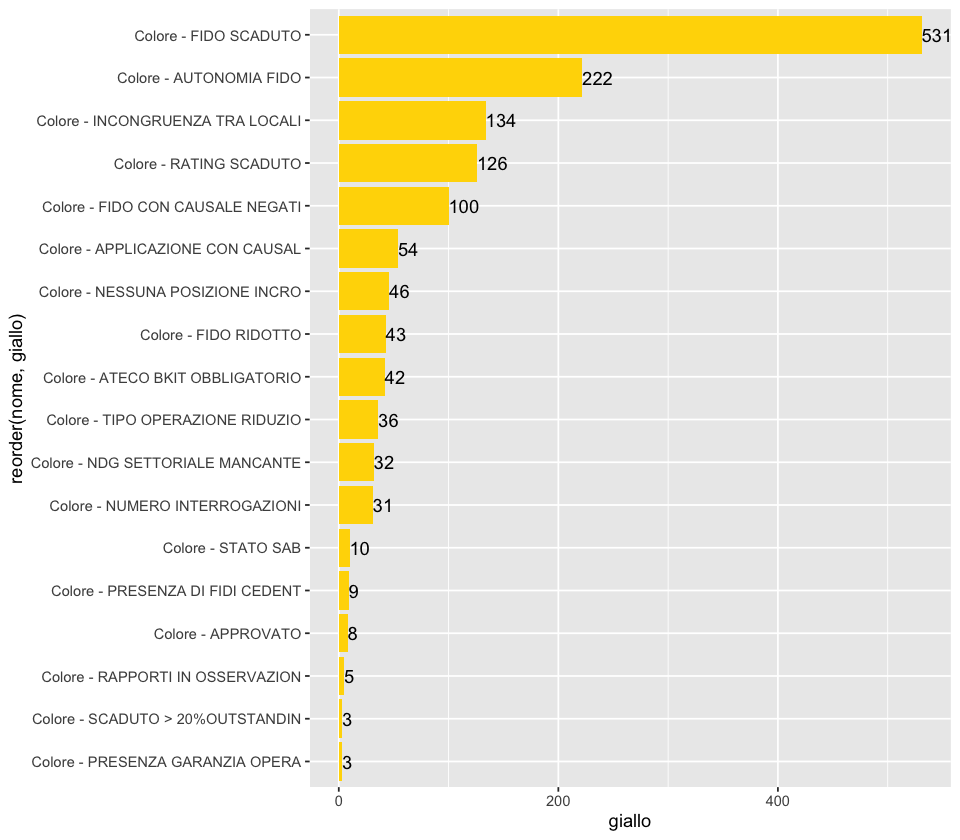

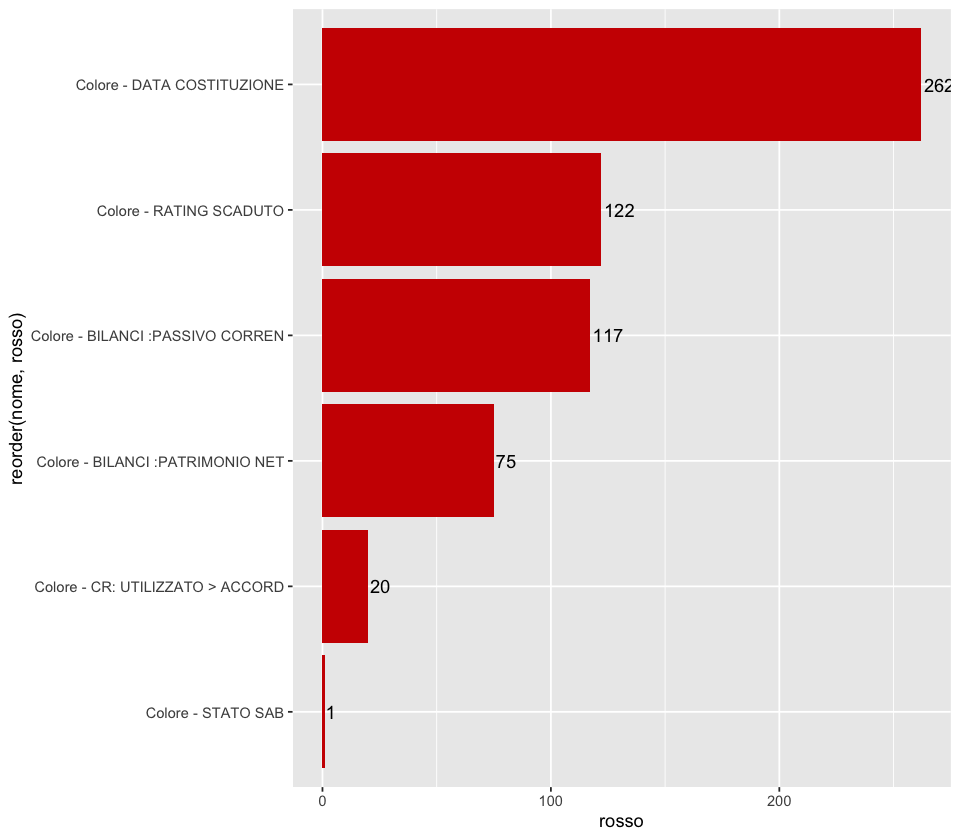

In [86]:
p<-ggplot(data=dt_count[giallo >0,], 
                      aes(x=reorder(nome,giallo), 
                          y=giallo)) + 
                geom_bar(stat="identity", fill="gold") + coord_flip()   +
                geom_text(aes(label=giallo), hjust=0)

            p

ggsave(
                filename = 'analisi_newverdi_bonis_gialli_sme.png', 
                width = 300, height = 450,
                units = "mm",
                dpi = 320,
                p
            )

p<-ggplot(data=dt_count[rosso >0,], 
                      aes(x=reorder(nome,rosso), 
                          y=rosso
                         )) + 
                geom_bar(stat="identity", fill="red3") + coord_flip()  +
                geom_text(aes(label=rosso), hjust=-0.1)

            p
ggsave(
                filename = 'analisi_newverdi_bonis_rossi_sme.png', 
                width = 300, height = 450,
                units = "mm",
                dpi = 320,
                p
            )

In [87]:
dt_analisi_rossi <-dt_color_conpred[target == 'DEFAULT' & col_new_vpc == "VERDE"& ESITO_FINALE_VPC == "ROSSO",..cols_color ]

# dt_analisi_giallo <-dt_color_conpred[target == 'DEFAULT' & col_new_vpc == "VERDE"& ESITO_FINALE_VPC == "GIALLO",..cols_color ]

In [88]:
dt_count_rossi <- rbindlist(lapply(colnames(dt_analisi_rossi), function(col){
    
    data.table(nome = col, rosso = nrow(dt_analisi_rossi[get(col)==5,]) )
}))

dt_count_rossi[rosso >0,]

nome,rosso
<chr>,<int>
Colore - RATING SCADUTO,1
Colore - BILANCI :PATRIMONIO NET,3
Colore - BILANCI :PASSIVO CORREN,2
Colore - DATA COSTITUZIONE,9


## ESTRAZIONE RAMI PRINCIPALI

In [111]:
model_frame_foglie <- model_frame[ type != "other"]
model_frame_foglie[, perc := round(100*n/sum(n),1)]


var,n,wt,dev,yval,complexity,ncompete,nsurrogate,yval2.V1,yval2.V2,yval2.V3,yval2.V4,yval2.V5,yval2.nodeprob,type,perc
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
<leaf>,37,37,12,1,1e-04,0,0,1,25,12,0.67567568,0.3243243,0.0005587098,leaf,0.1
<leaf>,66,66,32,1,1e-04,0,0,1,34,32,0.51515152,0.4848485,0.0009966175,leaf,0.1
<leaf>,42,42,13,2,1e-04,0,0,2,13,29,0.30952381,0.6904762,0.0006342112,leaf,0.1
<leaf>,94,94,17,2,1e-04,0,0,2,17,77,0.18085106,0.8191489,0.0014194250,leaf,0.1
<leaf>,33,33,16,1,1e-04,0,0,1,17,16,0.51515152,0.4848485,0.0004983088,leaf,0.0
<leaf>,424,424,55,2,0e+00,0,0,2,55,369,0.12971698,0.8702830,0.0064025127,leaf,0.6
<leaf>,473,473,38,2,0e+00,0,0,2,38,435,0.08033827,0.9196617,0.0071424257,leaf,0.7
<leaf>,42,42,14,1,1e-04,0,0,1,28,14,0.66666667,0.3333333,0.0006342112,leaf,0.1
<leaf>,68,68,22,2,1e-04,0,0,2,22,46,0.32352941,0.6764706,0.0010268181,leaf,0.1


In [124]:
dt_esempi <- rbindlist(lapply(unique(dt_sample$pred_vpc), function(s){
    dt <- head(dt_sample[pred_vpc == s,],1)
}))

In [215]:
dt_rules <- setDT(unique(rpart.predict(modello_smer$model,newdata= dt_esempi, rules = TRUE)))

In [216]:
colnames(dt_rules) <- c('DEFAULT',"OK","ramo")
dt_rules <- dt_rules[,.(DEFAULT,ramo)]

dt_rules[, nodi := str_count(ramo, "&")+1]
dt_rules[,ramo := gsub("\\s+"," ",ramo)]
dt_rules[,ramo := gsub("&","& ____",ramo)]
dt_rules[,ramo := gsub("____","\n\n",ramo)]


In [217]:
dt_rules <- merge(dt_rules,
                 model_frame_foglie[,.(yval2.V4,perc)],
                 by.x = 'DEFAULT',
                 by.y = 'yval2.V4',
                 all.x = TRUE)


In [218]:
dt_rules[, microsettore := gsub('\\s+'," ",gsub('[a-z,&]',"",str_extract_all(ramo, "microsett is .+&")))]

mapping_settori <- unique(master_modello[,.(AT_sett_desc,AT_cod_microsett)])

dt_rules <- rbindlist(lapply((1:nrow(dt_rules)),function(i){
    dt<- dt_rules[i,]
     dt[,settore_desc := paste(unique(mapping_settori[AT_cod_microsett %in% unlist(strsplit(microsettore," ")),AT_sett_desc]),collapse = "; ")]
#     dt
    
}))

In [219]:
write.xlsx(dt_rules[order(-perc)],'tabella_rami_sme.xlsx')
dt_rules

DEFAULT,ramo,nodi,perc,microsettore,settore_desc
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
0.01043930,because EWS_ASIS < 1.5 & AT_cod_microsett is ABCON01 or ABCON02 or ABCON03 or AEROS01 or AGRIC04 or AGRIC05 or ALIMD01 or ALIMP03 or ALIMP05 or APMED01 or APMED02 or ASERV01 or ASERV02 or ASERV03 or ASERV05 or ASERV07 or ASERV08 or ASERV11 or ASSIC01 or AUTOP01 or AUTOP02 or CHIMI01 or CHIMI02 or CHIMI04 or CHIMI06 or CHIMI07 or CHIMI08 or CHIMI09 or COMPO01 or COMPO02 or COMPO05 or COMPO06 or COSTR01 or DETTA01 or DETTA02 or DETTA04 or DIFES01 or DIFES02 or DUREP02 or DUREP03 or DUREP04 or ESTRA02 or FARMD01 or FARMD02 or FARMP01 or FARMP02 or FINSE01 or GIOAZ01 or HARDW01 or HARDW02 or HARDW03 or HARDW04 or HARDW05 or HOLDI01 or HOLDI02 or IMMOB01 or IMMOB03 or IMMOB04 or INFRA01 or INFRA02 or INFRA06 or INFRA07 or INGRO02 or ISTRU01 or ISTRU02 or LEGNO01 or MACCH01 or MAIMG01 or MAIMG02 or MAIMG03 or MAIMG04 or MAIMG05 or MAIMG06 or MAIMG07 or MAIMS01 or MAIMS02 or MAIMS03 or MAIMS04 or MAIMS05 or MAIMS07 or MAIMS08 or MATCO02 or MATCO03 or MATCO04 or MATCO06 or METAL01 or METAL03 or OILGA01 or OILGA03 or OILGA04 or OILGA06 or OILGA08 or POWER01 or PRODM01 or RACTR01 or RACTR05 or SERVA01 or SILVI01 or SOFTW01 or SOFTW02 or TABAC01 or TABAC02 or TABAC03 or TABAC04 or TESSP04 or TESSP05 or TESSP06 or TESSP07 or TRASP01 or TRASP02 or TRASS02 or TRASS03 or TRASS04 or TRASS07 or TRASS08 or TRASS09 or TRASS13 or TURAL02 or TURRI01 or missing & AT_eta_soc >= 11,3,32.0,ABCON01 ABCON02 ABCON03 AEROS01 AGRIC04 AGRIC05 ALIMD01 ALIMP03 ALIMP05 APMED01 APMED02 ASERV01 ASERV02 ASERV03 ASERV05 ASERV07 ASERV08 ASERV11 ASSIC01 AUTOP01 AUTOP02 CHIMI01 CHIMI02 CHIMI04 CHIMI06 CHIMI07 CHIMI08 CHIMI09 COMPO01 COMPO02 COMPO05 COMPO06 COSTR01 DETTA01 DETTA02 DETTA04 DIFES01 DIFES02 DUREP02 DUREP03 DUREP04 ESTRA02 FARMD01 FARMD02 FARMP01 FARMP02 FINSE01 GIOAZ01 HARDW01 HARDW02 HARDW03 HARDW04 HARDW05 HOLDI01 HOLDI02 IMMOB01 IMMOB03 IMMOB04 INFRA01 INFRA02 INFRA06 INFRA07 INGRO02 ISTRU01 ISTRU02 LEGNO01 MACCH01 MAIMG01 MAIMG02 MAIMG03 MAIMG04 MAIMG05 MAIMG06 MAIMG07 MAIMS01 MAIMS02 MAIMS03 MAIMS04 MAIMS05 MAIMS07 MAIMS08 MATCO02 MATCO03 MATCO04 MATCO06 METAL01 METAL03 OILGA01 OILGA03 OILGA04 OILGA06 OILGA08 POWER01 PRODM01 RACTR01 RACTR05 SERVA01 SILVI01 SOFTW01 SOFTW02 TABAC01 TABAC02 TABAC03 TABAC04 TESSP04 TESSP05 TESSP06 TESSP07 TRASP01 TRASP02 TRASS02 TRASS03 TRASS04 TRASS07 TRASS08 TRASS09 TRASS13 TURAL02 TURRI01,"Software e Servizi IT; Servizi di assistenza sanitaria; Farmaceutica e Biotecnologie - Distribuzione; Alimentare e bevande - Produzione; Altri servizi; Prodotti in metallo; Turismo - Ristorazione; Macchinari e altre attrezzature - Ingrosso; Macchine per impieghi speciali; Trasporti - Servizi; Costruzioni - Edilizia; Turismo - Alloggio e Agenzie di viaggio; Chimica, Gomma e Plastica; Legno e carta; Ingrosso - Altro; Dettaglio - Altro; Assicurazioni; Alimentare e bevande - Distribuzione; Materiali costruzioni; Oil and Gas; Infrastrutture; Tessile, abbigliamento e lusso - Produzione; Immobiliare; Silvicoltura e altre attività forestali; Financial services; Macchine per impieghi generali; Tabacco; Durevoli - Produzione; Altri beni di consumo; Gioco d'azzardo; Istruzione; Estrazione; Agricoltura, pesca e allevamento; Power Generation; Metallurgia; Hardware e Semiconduttori; Holding; Componenti e apparecchiature elettriche; Apparecchiature medicali; Raccolta e trattamento dei rifiuti; Trasporti - Produzione; Automotive - Produzione; Difesa; Farmaceutica e Biotecnologie - Produzione; Aerospace"
0.01927248,because EWS_ASIS < 1.5 & AT_cod_microsett is ABCON01 or ABCON02 or ABCON03 or AEROS01 or AGRIC04 or AGRIC05 or ALIMP05 or APMED01 or APMED02 or ASERV02 or ASERV08 or ASERV11 or ASSIC01 or AUTOP02 or CHIMI01 or CHIMI02 or CHIMI04 or CHIMI07 or CHIMI08 or DETTA02 or DETTA04 or DUREP02 or DUREP03 or DUREP04 or ESTRA02 or FARMD01 or FARMD02 or FARMP02 or FINSE01 or GIOAZ01 or HARDW01 or HARDW02 or HARDW04 or HARDW05 or HOLDI01 or HOLDI02 or IMMOB0

### SOGLIE

In [ ]:
dt_tree

In [ ]:
td_campione <- sum(dt_sample$target == 'DEFAULT')/nrow(dt_sample)

td_verde <- seq(0.5*td_campione, 0.8*td_campione, length.out = 6)

num_gialli <- seq(0.01*nrow(dt_sample), 0.04*nrow(dt_sample), length.out = 6)



In [ ]:
td_campione
td_verde
num_gialli

In [ ]:
dt_tree

In [ ]:
i = 4
s_vg <- tail(dt_tree[td_cumulato <=td_verde[i] ,]$pred_vpc,1)

dt_foglie_g_r <- dt_tree[td_cumulato > td_verde[i] ,]
dt_foglie_g_r[, cum_n := cumsum(tot)]
dt_foglie_g_r

In [ ]:
j <- 3
dt_foglie_g_r[cum_n <= num_gialli[j] ,]

s_g_r <- tail(dt_foglie_g_r[cum_n <= num_gialli[j] ,]$pred_vpc,1)

table_soglie(modello_smer$tree_table,soglie = c(s_vg,s_g_r),)

## CROSS VALIDATION

In [ ]:
lista_auc2 <- lapply(c(1111), function(seed){
    
    modello_smer <- compute_model(
    master_modello_fill[flag_exante == 'NO',..cols_modello],
    suffix="sme_V4",cp = 0.0001,seed = seed,minbuck= 0.0005, 
    use_surr = 1, perc_split = 0.80,desc = 'sme')
    
  
    dt_pred_tree <- merge(modello_smer$pred,unique(model_frame[type =='leaf',.(yval2.V4,type)]),by.x ='pred_vpc', by.y = 'yval2.V4', all.x = TRUE )

pred_test <- prediction(predict(modello_smer$model, dt_pred_tree, type="prob")[, 2], dt_pred_tree$target)

auc_ROCR <- performance(pred_test, measure = "auc")
print(auc_ROCR@y.values[[1]])

#png(paste0('cross_val/plot_smev4', seed,'.jpg'))
plot( x = performance(pred_test, measure = "tpr", x.measure = "fpr")@x.values[[1]],y = performance(pred_test, measure = "tpr", x.measure = "fpr")@y.values[[1]],type="p", pch = 16,col = 'forestgreen',ylab = 'True positive rate', main =round(auc_ROCR@y.values[[1]],2), xlab = 'False positive rate',)
abline(0,1, lty = 2)
#dev.off()
    return(auc_ROCR@y.values[[1]])
})

#names(lista_auc2)<- c(1111,10311,33433,45343,651194,12323,4343,532)

In [ ]:
(sum(unlist(lista_auc2))-0.518970910228339)/(length(lista_auc2)-1)
lista_auc2

## ANALISI SOGLIE DI TAGLIO NELL'ALBERO

In [ ]:
txt <- readr::read_file('output/20220614/tree_sme_V4_1.xml')

In [ ]:
library(stringr)

In [ ]:
##CR
lista_raw <- unlist(str_extract_all(gsub('"',"",txt), 'field=CR_sconf_acc.+/>'))
lista_soglie_cr <- gsub('field=',"",lista_raw)
lista_soglie_cr <- gsub('operator=',"",lista_soglie_cr)
lista_soglie_cr <- gsub('value=',"",lista_soglie_cr)
lista_soglie_cr <- gsub('/>',"",lista_soglie_cr)
lista_soglie_cr <- gsub('greaterOrEqual',">=",lista_soglie_cr)
lista_soglie_cr <- gsub('lessThan',"<",lista_soglie_cr)

data.table(lista_soglie_cr)

In [ ]:
##BIL_Oneri_ebitda
lista_raw <- unlist(str_extract_all(gsub('"',"",txt), 'field=BIL_onerifin_ebitda.+/>'))
lista_soglie_oneri <- gsub('field=',"",lista_raw)
lista_soglie_oneri <- gsub('operator=',"",lista_soglie_oneri)
lista_soglie_oneri <- gsub('value=',"",lista_soglie_oneri)
lista_soglie_oneri <- gsub('/>',"",lista_soglie_oneri)
lista_soglie_oneri <- gsub('greaterOrEqual',">=",lista_soglie_oneri)
lista_soglie_oneri <- gsub('lessThan',"<",lista_soglie_oneri)
data.table(lista_soglie_oneri)

In [ ]:
##BIL_PFN_ebitda
lista_raw <- unlist(str_extract_all(gsub('"',"",txt), 'field=BIL_PFN_Ebitda.+/>'))
lista_soglie_pfn <- gsub('field=',"",lista_raw)
lista_soglie_pfn <- gsub('operator=',"",lista_soglie_pfn)
lista_soglie_pfn <- gsub('value=',"",lista_soglie_pfn)
lista_soglie_pfn <- gsub('/>',"",lista_soglie_pfn)
lista_soglie_pfn <- gsub('greaterOrEqual',">=",lista_soglie_pfn)
lista_soglie_pfn <- gsub('lessThan',"<",lista_soglie_pfn)

data.table(lista_soglie_pfn)

In [ ]:
unlist(str_extract_all(gsub('"',"",txt), 'field=CR_sconf_acc.+/>'))

## analisi variabili

In [ ]:
require(arules)
dt_appo <- copy(master_modello_filt) 

 dt_appo[AT_eta_soc >= 1,ETA :=round(AT_eta_soc)]
dt_appo[AT_eta_soc < 1 &AT_eta_soc >0  ,ETA :=round(AT_eta_soc,1)]
dt_appo[AT_eta_soc < 0,ETA :=-1]
dt_appo[AT_eta_soc > 30,ETA :=30]

df <- dt_appo[, 
.( tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
                td = 100*sum(target =='DEFAULT')/.N), by = ETA]
df[,color := 'A']
df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']

df[,td_medio := 100*sum(DEFAULT)/sum(tot)]
df[,perc_sample :=round(100*tot/sum(tot),3)]
df[order(td)]


p<-ggplot(data=df, aes(x=factor(ETA, levels= sort(unique(ETA), decreasing = FALSE)), y=td, fill = color)) +
        geom_bar(stat="identity") + coord_flip()+ 
        scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+
        geom_text(aes(label=perc_sample), hjust=-0.1)
p

 ggsave(
        filename = 'plot_eta.png', 
        width = 400, height = 500,
        units = "mm",
        dpi = 320,
        p
    )
table(dt_appo$ETA)

In [ ]:
nrow(dt_appo)

In [ ]:
dt_appo[,flag_anno := ]

In [ ]:



dt_appo[BIL_PFN_Ebitda >= 1 & BIL_PFN_Ebitda < -50,pdf_ebi :=round(BIL_PFN_Ebitda)]
dt_appo[BIL_PFN_Ebitda <= -1 & BIL_PFN_Ebitda > -50,pdf_ebi :=round(BIL_PFN_Ebitda)]
dt_appo[BIL_PFN_Ebitda < 1 &BIL_PFN_Ebitda >0  ,pdf_ebi :=round(BIL_PFN_Ebitda,1)]
dt_appo[BIL_PFN_Ebitda < 0 &BIL_PFN_Ebitda >-1  ,pdf_ebi :=round(BIL_PFN_Ebitda,1)]
dt_appo[BIL_PFN_Ebitda >30 & BIL_PFN_Ebitda< 2000,pdf_ebi :=30]
dt_appo[BIL_PFN_Ebitda < -30 & BIL_PFN_Ebitda  > -2000,pdf_ebi :=-30]
dt_appo[BIL_PFN_Ebitda > 2000,pdf_ebi :=9999999]
dt_appo[BIL_PFN_Ebitda <  -2000,pdf_ebi :=-9999999]

df <- dt_appo[, 
.( tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
                td = 100*sum(target =='DEFAULT')/.N), by = pdf_ebi]
df[,color := 'A']
df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']

df[,td_medio := 100*sum(DEFAULT)/sum(tot)]
df[,perc_sample :=round(100*tot/sum(tot),3)]
df[order(td)]


p<-ggplot(data=df, aes(x=factor(pdf_ebi, levels= sort(unique(pdf_ebi), decreasing = FALSE)), y=td, fill = color)) +
        geom_bar(stat="identity") + coord_flip()+ 
        scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+
        geom_text(aes(label=perc_sample), hjust=-0.1)
p

 ggsave(
        filename = 'plot_pfn_ebitda.png', 
        width = 400, height = 500,
        units = "mm",
        dpi = 320,
        p
    )

In [ ]:



dt_appo[BIL_PFN_Ebitda < 0 ,classi_pfn_ebitda  := -1]
dt_appo[BIL_PFN_Ebitda >= 0 & BIL_PFN_Ebitda <3.5,classi_pfn_ebitda  := 3.5]
dt_appo[BIL_PFN_Ebitda >= 3.5 & BIL_PFN_Ebitda < 4.5,classi_pfn_ebitda  := 4.5]
dt_appo[BIL_PFN_Ebitda >= 4.5,classi_pfn_ebitda  := 10]


df <- dt_appo[, 
.( tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
                td = 100*sum(target =='DEFAULT')/.N), by = classi_pfn_ebitda]
df[,color := 'A']
df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']

df[,td_medio := 100*sum(DEFAULT)/sum(tot)]
df[,perc_sample :=round(100*tot/sum(tot),3)]
df[order(td)]


p<-ggplot(data=df, aes(x=factor(classi_pfn_ebitda, levels= sort(unique(classi_pfn_ebitda), decreasing = FALSE)), y=td, fill = color)) +
        geom_bar(stat="identity") + coord_flip()+ 
        scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+
        geom_text(aes(label=perc_sample), hjust=-0.1)
p

 ggsave(
        filename = 'plot_pfn_ebitda_classi.png', 
        width = 400, height = 500,
        units = "mm",
        dpi = 320,
        p
    )

In [ ]:
dt_appo[CR_sconf_acc <  -100,sconf_acc := 'missing']
dt_appo[CR_sconf_acc > 100,sconf_acc := 'inf']
dt_appo[CR_sconf_acc == 0,sconf_acc := '0']
dt_appo[CR_sconf_acc > 0 & CR_sconf_acc<=100,sconf_acc := '>0']

In [ ]:
table(dt_appo$sconf_acc,useNA = 'always')

In [ ]:
df <- dt_appo[, 
.( tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
                td = 100*sum(target =='DEFAULT')/.N), by = sconf_acc]
df[,color := 'A']
df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']

df[,td_medio := 100*sum(DEFAULT)/sum(tot)]
df[,perc_sample :=round(100*tot/sum(tot),3)]
df[order(td)]


p<-ggplot(data=df, aes(x=reorder(sconf_acc,td), y=td, fill = color)) +
                geom_bar(stat="identity") + coord_flip()  + 
                scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+
                geom_text(aes(label=perc_sample), hjust=-0.1)
            p
 ggsave(
        filename = 'plot_sconf_acc.png', 
        width = 400, height = 500,
        units = "mm",
        dpi = 320,
        p
    )

In [ ]:
dt_appo[BIL_onerifin_ebitda

In [ ]:
lista_master$bil

In [ ]:

EW

In [ ]:

cat("EWS    ",round(100*nrow(master_modello[is.na(EWS_ASIS),])/nrow(master_modello),1))
cat("\nRATING    ",round(100*nrow(master_modello[is.na(RAT_classe_rating_filt),])/nrow(master_modello),1))
cat("\nCR    ",round(100*nrow(master_modello[is.na(CR_accordato),])/nrow(master_modello),1))